# Statistiques Descriptives 2016

On se concentre sur l'année 2016, qui est celle pour laquelle les données sont les plus complètes. 

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
fqms_2016 = pd.read_csv("fqms_2016.csv",low_memory=False)
histo_2016 = pd.read_csv("histo_2016.csv")

## 0. Création de dates exploitables pour les FQMs :

In [74]:
histo_2016 = histo_2016.astype({'Jour': 'datetime64[ns]'})

In [75]:
# jour 1 de la semaine 1 en 2016 : 4 janvier
jour_1 = np.datetime64('2016-01-04')

In [76]:
fqms_2016['Delta date'] = (fqms_2016['Semaine']-1)*7 + (fqms_2016['Jour']-1)

In [77]:
fqms_2016['Date'] = fqms_2016['Delta date'].apply(lambda x: jour_1 + np.timedelta64(x, 'D'))

## 1. Vérification des nombres de sièges attribués :

In [11]:
nb_sieges = histo_2016['Sièges Corrections_ICI'].count()
nb_vols = histo_2016['Jour'].count()

print("Nb sièges renseignés :",nb_sieges)
print("Nb vols des histos :",nb_vols)
print('Pourcentage sièges renseignés : ',nb_sieges*100/nb_vols,'%')

Nb sièges renseignés : 151880
Nb vols des histos : 711444
Pourcentage sièges renseignés :  21.348131405985573 %


On a seulement 21,3% des vols qui ont pu se voir attribués des nombres de sièges prévus. C'est assez représentatif de la complétude de la base globale à ce niveau (21,5% toutes années confondues).

Vérifions la cohérence des estimations du nombre de sièges avec le nombre de passagers réalisés :
- Vérification que l'on a pas plus de passagers que de sièges
- Histogramme de la répartition des écarts entre passagers réalisés / nombre de sièges pour vérifier qu'il n'y a pas de grosses incohérences...

In [17]:
histo_2016['Dif. sièges - passagers']=histo_2016['Sièges Corrections_ICI']-histo_2016['Nombre de passagers réalisés']

Text(0.5, 0.98, 'Répartition des différences entre nombre de sièges estimés et passagers réalisés (pour les valeurs renseignées)')

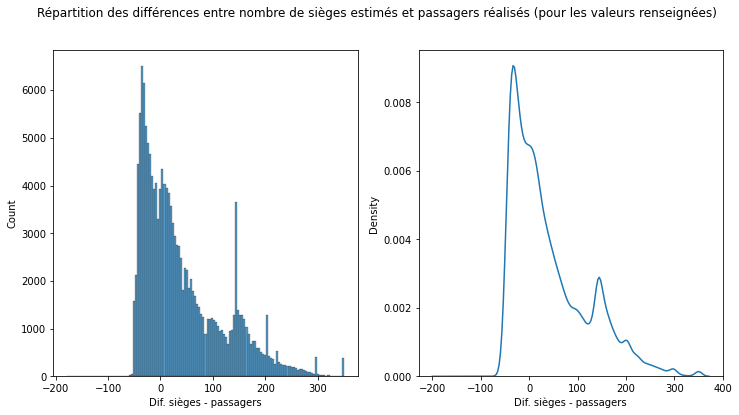

In [28]:
fig,ax = plt.subplots(1, 2, figsize=(12,6)) 

sns.histplot(data=histo_2016,x='Dif. sièges - passagers',ax=ax[0])
sns.kdeplot(data=histo_2016,x='Dif. sièges - passagers',ax=ax[1])

fig.suptitle("Répartition des différences entre nombre de sièges estimés et passagers réalisés (pour les valeurs renseignées)")

<AxesSubplot:xlabel='Dif. sièges - passagers', ylabel='Density'>

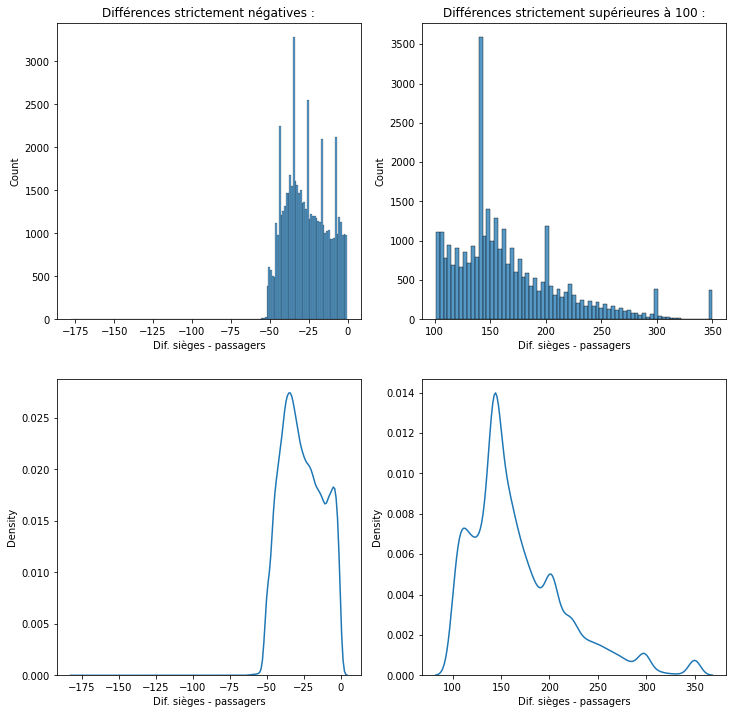

In [30]:
fig,ax = plt.subplots(2, 2, figsize=(12,12)) 

ax[(0,0)].set_title("Différences strictement négatives :")
sns.histplot(data=histo_2016[histo_2016['Dif. sièges - passagers']<0],x='Dif. sièges - passagers',ax=ax[(0,0)])
sns.kdeplot(data=histo_2016[histo_2016['Dif. sièges - passagers']<0],x='Dif. sièges - passagers',ax=ax[(1,0)])

ax[(0,1)].set_title("Différences strictement supérieures à 100 :")
sns.histplot(data=histo_2016[histo_2016['Dif. sièges - passagers']>100],x='Dif. sièges - passagers',ax=ax[(0,1)])
sns.kdeplot(data=histo_2016[histo_2016['Dif. sièges - passagers']>100],x='Dif. sièges - passagers',ax=ax[(1,1)])


## 2. Comparaisons nombre de passagers réalisés/estimés par faisceaux

On commence par regarder comment les faisceaux sont codés dans les deux bases :

In [35]:
fqms_2016[['Faisceau','Qualité']].drop_duplicates()

,Faisceau,Qualité
0,1,MTP
15,2,SCH
62,3,DTM
72,4,CEE
73,5,INT


In [36]:
histo_2016[['Faisceau facturation']].drop_duplicates()

,Faisceau facturation
0,International
1,Schengen
4,Dom Tom
5,National
123,Autre UE
18517,NaN


*Il manque 10 faisceaux de facturations dans la base histos...*

In [38]:
faisceaux = ["National","Schengen","Dom Tom","Autre UE","International"]

On va commencer par visualiser au jour le jour (en sommant le nombre de passagers réalisés par jour) :

Text(0.5, 0.98, 'Comparaison entre nombre de passagers réalisés et estimés par jour (somme) sur chaque faisceau :')

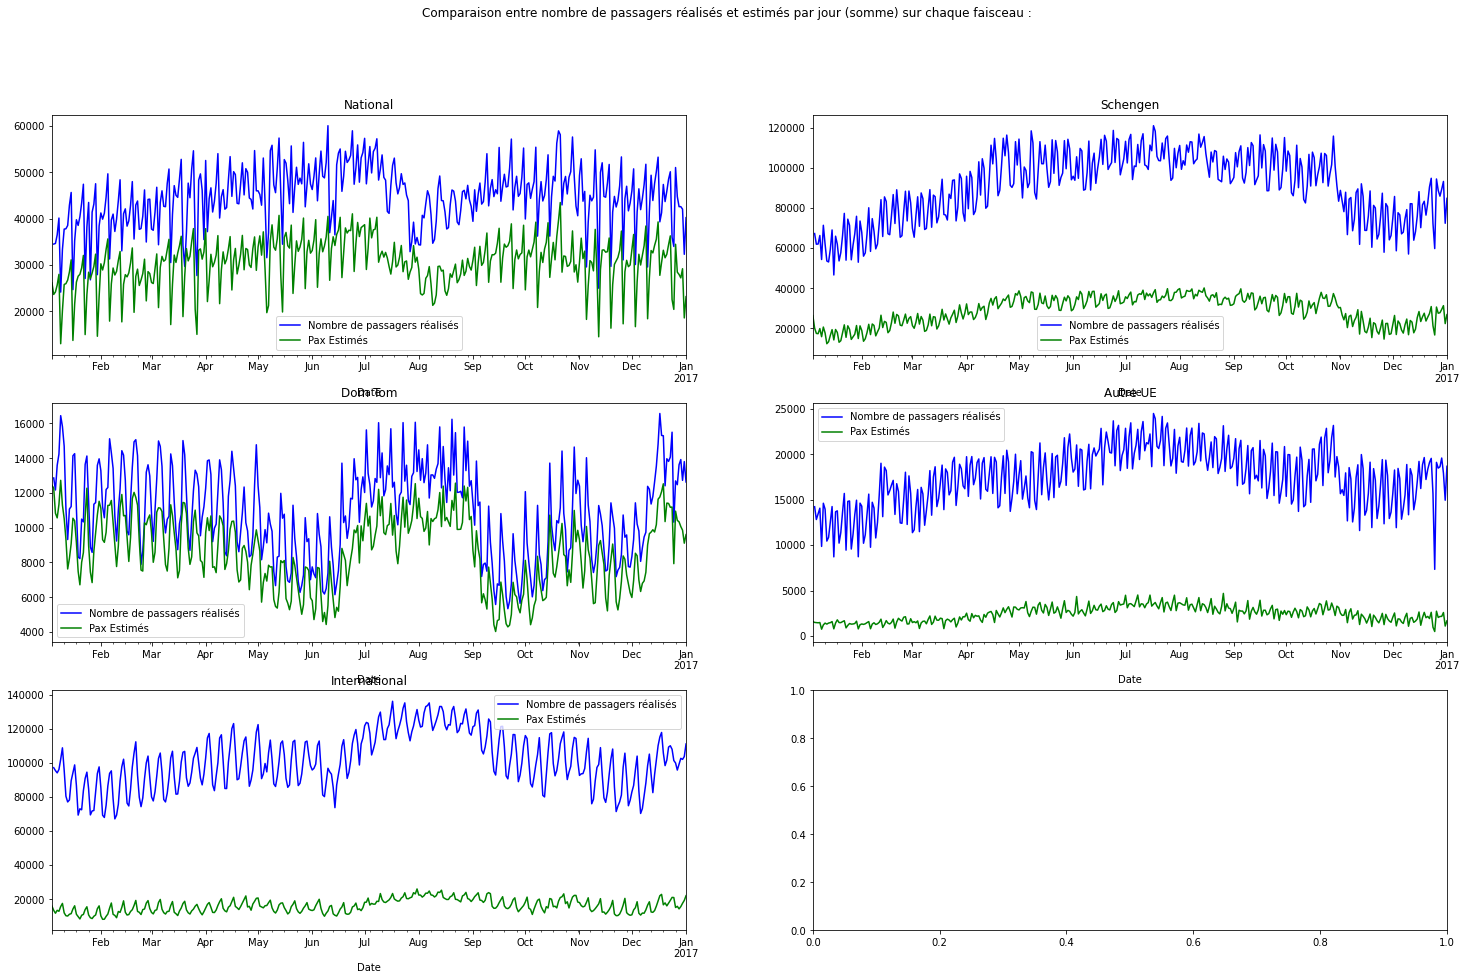

In [82]:
fig, ax = plt.subplots(3,2, figsize=(25,15))

for i in range(5) :
    ax[(i//2,i%2)].set_title(faisceaux[i])
    
    histo_2016[histo_2016['Faisceau facturation'].isin([faisceaux[i]])].groupby('Jour').agg({'Nombre de passagers réalisés':'sum'}).plot(ax = ax[(i//2,i%2)],legend=True, subplots=True,color='blue')
    fqms_2016[fqms_2016['Faisceau'].isin([i+1])].groupby('Date').agg({'Pax Estimés':'sum'}).plot(ax = ax[(i//2,i%2)],legend=True, subplots=True,color='green')
    
fig.suptitle('Comparaison entre nombre de passagers réalisés et estimés par jour (somme) sur chaque faisceau :')

Zoom sur ce qui s'est passé entre janvier et avril, pour les faisceaux 'National' et 'Dom-Tom', qui sont les plus convainquants : 

Text(0.5, 0.98, 'Comparaison entre nombre de passagers réalisés et estimés par jour (somme) entre janvier et avril :')

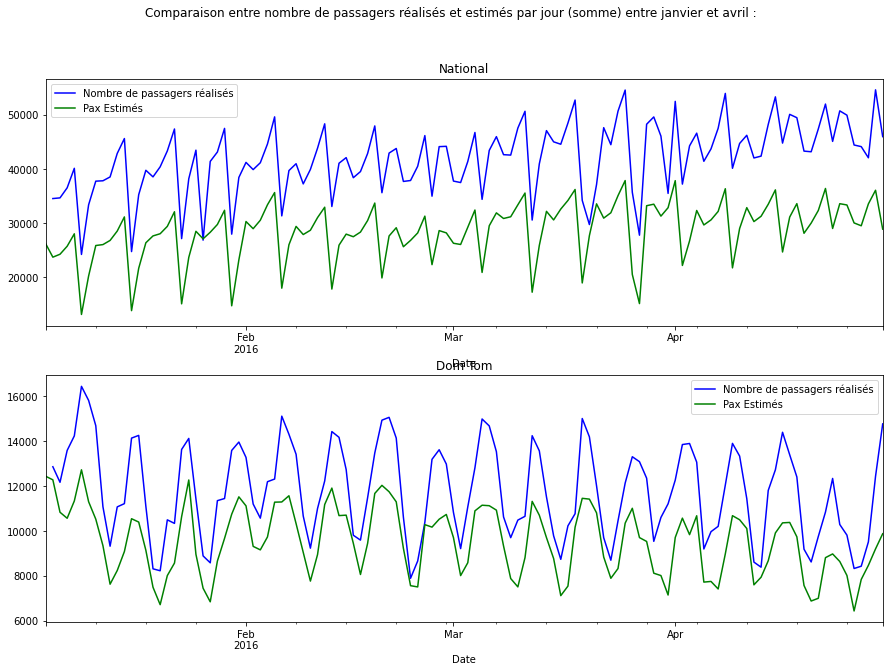

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))

histo_tronque = histo_2016[histo_2016['Jour']<np.datetime64('2016-05-01')]
fqms_tronque = fqms_2016[fqms_2016['Date']<np.datetime64('2016-05-01')]

for i in [0,2] :
    ax[i//2].set_title(faisceaux[i])
    
    histo_tronque[histo_tronque['Faisceau facturation'].isin([faisceaux[i]])].groupby('Jour').agg({'Nombre de passagers réalisés':'sum'}).plot(ax = ax[i//2],legend=True, subplots=True,color='blue')
    fqms_tronque[fqms_tronque['Faisceau'].isin([i+1])].groupby('Date').agg({'Pax Estimés':'sum'}).plot(ax = ax[i//2],legend=True, subplots=True,color='green')

fig.suptitle('Comparaison entre nombre de passagers réalisés et estimés par jour (somme) entre janvier et avril :')